<a href="https://colab.research.google.com/github/VisionLogic-AI/Brain_Projects/blob/master/Brain_Segmentation_(Histological_Sections).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#get custom scripts for receptive field calculation
!wget -nc https://raw.githubusercontent.com/hspitzer/histo-seg/master/receptive_field.py

--2020-05-17 14:46:22--  https://raw.githubusercontent.com/hspitzer/histo-seg/master/receptive_field.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15316 (15K) [text/plain]
Saving to: ‘receptive_field.py’

receptive_field.py  100%[===================>]  14.96K  --.-KB/s    in 0s      

2020-05-17 14:46:22 (37.0 MB/s) - ‘receptive_field.py’ saved [15316/15316]



In [0]:
#import libs
import keras
import numpy as np
from keras.layers.convolutional import Convolution2D
from keras.layers import Input, UpSampling2D, MaxPooling2D, Concatenate, Cropping2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import imageio
import os
import re
import glob
from tqdm import tqdm
import pickle
from receptive_field import calculate_receptive_field, suggest_input_sizes

%matplotlib inline

#Download Train, Val & Test Data
*This data was prepared with the **create_datasets.ipynb** notebook

In [7]:
data_dir= 'data'

data_url= 'https://fz-juelich.sciebo.de/s/tFG1H8bAJfyok3E/download'
data_archive= os.path.join(data_dir, 'data.zip')
!mkdir -p {data_dir}
!wget -nc {data_url} -O {data_archive}
!unzip -uo {data_archive} -d .

--2020-05-17 14:56:47--  https://fz-juelich.sciebo.de/s/tFG1H8bAJfyok3E/download
Resolving fz-juelich.sciebo.de (fz-juelich.sciebo.de)... 132.252.183.1
Connecting to fz-juelich.sciebo.de (fz-juelich.sciebo.de)|132.252.183.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/data.zip’

data/data.zip           [    <=>             ] 376.87M  9.24MB/s    in 44s     

2020-05-17 14:57:33 (8.52 MB/s) - ‘data/data.zip’ saved [395179821]

Archive:  data/data.zip
   creating: ./data/precomputed_models/
 extracting: ./data/precomputed_models/model_gmwm.hdf5  
 extracting: ./data/precomputed_models/model_gmwm.pickle  
 extracting: ./data/precomputed_models/model_gmwm_prediction.png  
 extracting: ./data/precomputed_models/model_v1.hdf5  
 extracting: ./data/precomputed_models/model_v1.pickle  
 extracting: ./data/precomputed_models/model_v1_epoch20.hdf5  
 extracting: ./data/precomputed_models/model_v1_epoch60.hdf5  
 extracti

In [8]:
#look at structure of data directory
!ls -R {data_dir} --ignore raw

#define paths to test images
sections_fname= os.path.join(data_dir, 'test/B20_{}.png')
masks_v1_fname= os.path.join(data_dir, 'test/B20_{}_v1.png')
masks_gmwm_fname= os.path.join(data_dir, 'test/B20_{}_gmwm.png')

#get section numbers for test images
def get_section_no(name):
  """Return last four digit number in the string name"""
  if isinstance(name, list):
    res= []
    for n in name:
      res.append(get_section_no(n))
    return res
  else:
    return re.findall(r'\d\d\d\d', name)[-1]

imgs= sorted(glob.glob(masks_v1_fname.format('*')))
test_sections= get_section_no(imgs)
print('Test sections', test_sections)

data:
data.zip	    train_gmwm.npz    val_gmwm.npz
precomputed_models  train_v1gmwm.npz  val_v1gmwm.npz
test		    train_v1.npz      val_v1.npz

data/precomputed_models:
model_gmwm.hdf5			     model_v1gmwm_epoch20.pickle
model_gmwm.pickle		     model_v1gmwm_epoch20_prediction.png
model_gmwm_prediction.png	     model_v1gmwm_epoch60.hdf5
model_v1_epoch20.hdf5		     model_v1gmwm_epoch60.pickle
model_v1_epoch60.hdf5		     model_v1gmwm_epoch60_prediction.png
model_v1gmwm_epoch10.hdf5	     model_v1.hdf5
model_v1gmwm_epoch10.pickle	     model_v1.pickle
model_v1gmwm_epoch10_prediction.png  model_v1_prediction.png
model_v1gmwm_epoch20.hdf5

data/test:
B20_0361_gmwm.png  B20_0721_v1.png    B20_1441.png	 B20_2161_gmwm.png
B20_0361.png	   B20_1081_gmwm.png  B20_1441_v1.png	 B20_2161.png
B20_0361_v1.png    B20_1081.png       B20_1801_gmwm.png  B20_2161_v1.png
B20_0721_gmwm.png  B20_1081_v1.png    B20_1801.png
B20_0721.png	   B20_1441_gmwm.png  B20_1801_v1.png
Test sections ['0361', '0721', '1081', '1

#Examine Iages and Labels
The aim of this notebook is to train CNN's for segmenting histological sections. First, we will consider gray/white matter segmentation. Second, we will try to extend the models to segment area V1 (primary visual cortex)

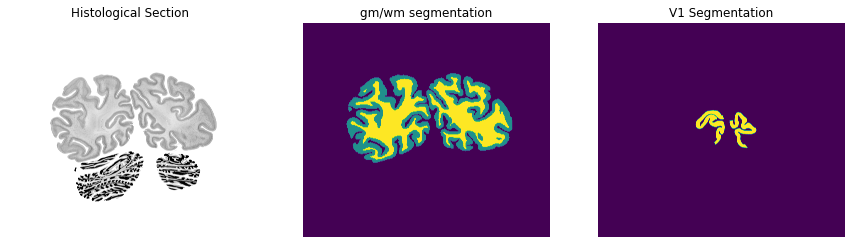

In [10]:
#load and display section and label
#first lets reformat of image sizes
img= imageio.imread(sections_fname.format('1081'))
mask_v1= imageio.imread(masks_v1_fname.format('1081'))
mask_gmwm= imageio.imread(masks_gmwm_fname.format('1081'))

#now lets plot the images and their axes
fig, axes= plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(img, cmap= 'gray')
axes[0].set_title('Histological Section')
axes[1].imshow(mask_gmwm)
axes[1].set_title('gm/wm segmentation')
axes[2].imshow(mask_v1)
axes[2].set_title('V1 Segmentation')
for ax in axes:
  ax.axis('off')

#Prepare Data for Training

In [12]:
print('Size of histological section:', img.shape, '({:.2f} MB)'.format(img.size/1024/1024))

Size of histological section: (5711, 6572) (35.79 MB)


**Challenge:**
Histological sections are too large to process at once during training:
  - GPU memory to small
  - effective number of training samples too low

**Solution:**
Crop small patches from input images and use for training

*Choices for patch sampling: *
  - How large should the input be?
  - How many patches should be sampled?
  - Where should the pathces be sampled from?

In this example we are using cropped patches that we prepared in advance.
If we are interested in seeing how this was done, we can take a look at this notebook:
create-datasets.ipynb

In [0]:
#load the train and val datasets
def load_dataset(dataset, data_dir= data_dir):
  res= np.load(os.path.join(data_dir, dataset))
  x= res['X']
  y= res['Y']
  res.close()
  return x,y

#load precomputed train and and val patches
x_train, y_train= load_dataset('train_gmwm.npz')
x_val, y_val= load_dataset('val_gmwm.npz')

In [0]:
def plot_dataset(x, y, num=5, vmin_x=0, vmax_x=255, vmax_y=2):
  """Visualize num examp;es from images x and labels y"""
  fig, axes= plt.subplots(2, num, figsize=(15,6))
  for i, ax in enumerate(axes[0]):
    ax.imshow(x[i,:,:0], cmap= 'gray', vmin= vmin_x, vmax= vmax_x)
    ax.axis('off')
    ax.set_title('image patch {}'.format(i))
  for i, ax in enumerate(axes[1]):
    ax.imshow(y[i,:,:,0], vmin=0, vmax= vmax_y)
    ax.axis('off')
    ax.set_title('Label patch {}'.format(i))
  return fig

print('Train dataset shape (n_samples, height, width, n_channels): {}'.format(x_train.shape))
print('Val dataset shape (n_samples, height, width, n_channels): {}'.format(x_val.shape))

#visualize image and label patches
fig= plot_dataset(x_train, y_train)
fig.suptitle('Example train patches')

fig= plot_dataset(x_val, y_val)
fig.suptitle('Example val patches')
  

#U-Net Architecture for Segmentation
U-Net is a good choice for segmentation.
  - fully convolutional, allows tiled prediction of veury large images
  - downsampling branch consisting of blocks of two convolutions and a pooling layer
  - upsampling branch consisting of an upsampling layer and two convolutions
  - skip connections, copy activations from downsampling branchs and concatenate with upsampling branch